In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


### Device Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Data Transforms and Loaders

In [4]:
IMAGE_SIZE = 224
batch_size = 32
data_path = "dataset/facial hair"

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

train_ds = ImageFolder(root=os.path.join(data_path, 'Train'), transform=transform)
val_ds = ImageFolder(root=os.path.join(data_path, 'Validate'), transform=transform)
test_ds = ImageFolder(root=os.path.join(data_path, 'Test'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Load and Modify EfficientNet-B0

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 2)
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\Induwara Jayasinghe/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:08<00:00, 2.46MB/s]


Loaded pretrained weights for efficientnet-b0


### Define Loss, Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training Loop

In [7]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    val_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.2f} - Val Acc: {val_acc:.2f}")

Epoch 1/10 - Loss: 12.3689 - Train Acc: 0.77 - Val Acc: 0.55
Epoch 2/10 - Loss: 7.2283 - Train Acc: 0.95 - Val Acc: 0.60
Epoch 3/10 - Loss: 3.7397 - Train Acc: 0.99 - Val Acc: 0.80
Epoch 4/10 - Loss: 1.7150 - Train Acc: 0.99 - Val Acc: 0.90
Epoch 5/10 - Loss: 1.1572 - Train Acc: 1.00 - Val Acc: 0.90
Epoch 6/10 - Loss: 0.8718 - Train Acc: 1.00 - Val Acc: 0.90
Epoch 7/10 - Loss: 1.3276 - Train Acc: 1.00 - Val Acc: 0.90
Epoch 8/10 - Loss: 1.2091 - Train Acc: 1.00 - Val Acc: 0.90
Epoch 9/10 - Loss: 0.7484 - Train Acc: 1.00 - Val Acc: 0.90
Epoch 10/10 - Loss: 0.6166 - Train Acc: 1.00 - Val Acc: 0.90


### Save Model

In [8]:
torch.save(model.state_dict(), "efficientnet_facial.pt")
print("Model saved as 'efficientnet_facial.pt'")

Model saved as 'efficientnet_facial.pt'


### Final Evaluation

In [9]:
def evaluate_model(model, loader, title="Test"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nEvaluation on {title} Set")
    print(classification_report(y_true, y_pred, target_names=train_ds.classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=train_ds.classes, yticklabels=train_ds.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


Evaluation on Test Set
              precision    recall  f1-score   support

       Beard       1.00      0.80      0.89        10
    No Beard       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



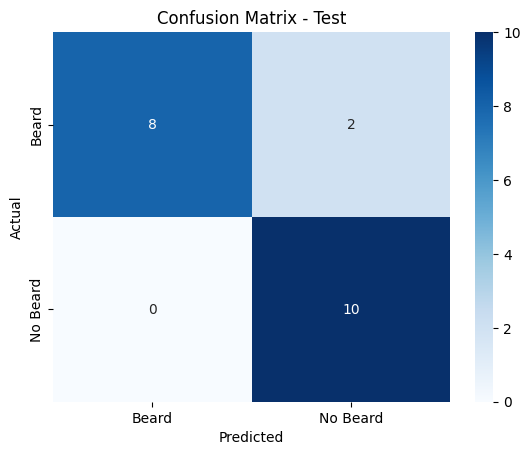

In [10]:
# Evaluate
evaluate_model(model, test_loader, title="Test")